# Notebook to extract and digitise a rhythm strip from 12 lead ECGs

## 📁 Project Structure

Organise your working directory like this:  
Create a folder ecg_extraction for this bit of the project. 

ecg_extraction/   
├── input/            → folder for input ECG PDFs.  
├── output/           → folder for processed images, plots, and data.  
├── requirements.txt  → list of packages to install with pip.  
└── ecg_notebook.ipynb → this notebook.  

Set your base path as the ecg_extraction folder.  
e.g. basepath = /mydocuments/research/ecg_extraction  

## ⚙️ Environment Setup

To run this notebook, you can either set up a local Python environment or use Google Colab in your browser.

### Option A — Local Python Environment (recommended)

Use either `venv` or `conda` to isolate your dependencies.  
I suggest Python 3.12. 

#### Using `venv`

```bash
python3.12 -m venv ecg_env
source ecg_env/bin/activate        # On Windows: ecg_env\Scripts\activate
pip install -r requirements.txt
```

#### Using `conda`
```bash
conda create -n ecg_env python=3.11.12
conda activate ecg_env
pip install -r requirements.txt
```
Note to self. In my setup I used the 'life' env.   

   
#### Option B — Google Colab (browser-based)  

If you don’t have a local Python setup, you can prototype in Colab.  
	1.	Go to colab.research.google.com. 
	2.	Upload this notebook and run it in the browser  
	3.	At the top of the notebook, add and run:  

```bash
!pip install numpy pandas matplotlib opencv-python scikit-image scipy pillow pytesseract pdf2image   
```  

### Remember:  
### Use only anonymized ECG data in Colab. Use it for prototyping, development and experimentation.  
### Never upload files containing patient names, dates of birth, IDs, or identifiable information.


## 📦 Required Imports  

In [54]:
# 🧠 Core imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np


# 🖼️ Image processing
import cv2
from PIL import Image
from pdf2image import convert_from_path

# 📐 Morphological processing
from skimage.morphology import skeletonize

# 📊 Signal processing
from scipy.signal import medfilt, savgol_filter

# 🔤 OCR  
import pytesseract


## 📁 Project Paths

In [55]:
# Define the base directory (where this notebook lives)
BASE_PATH = Path.cwd()

# Define subfolders for input ECG PDFs and output results
INPUT_FOLDER = BASE_PATH / "input"
PROCESSED_INPUT_FOLDER = INPUT_FOLDER / "processed_input"
OUTPUT_FOLDER = BASE_PATH / "output"

# Confirm paths for the student
print("✅ Paths set:")
print("  📂 Notebook directory:    ", BASE_PATH)
print("  📂 Input folder:          ", INPUT_FOLDER)
print("  📂 Processed Input folder:", PROCESSED_INPUT_FOLDER)
print("  📂 Output folder:         ", OUTPUT_FOLDER)

✅ Paths set:
  📂 Notebook directory:     /Users/seamus/Dropbox/Research/Beacon/SSRAs/SSRA2025/ecg_spirometry/ecg_extraction
  📂 Input folder:           /Users/seamus/Dropbox/Research/Beacon/SSRAs/SSRA2025/ecg_spirometry/ecg_extraction/input
  📂 Processed Input folder: /Users/seamus/Dropbox/Research/Beacon/SSRAs/SSRA2025/ecg_spirometry/ecg_extraction/input/processed_input
  📂 Output folder:          /Users/seamus/Dropbox/Research/Beacon/SSRAs/SSRA2025/ecg_spirometry/ecg_extraction/output


## 🗂️ Prepare ECG PDFs

Found 3 PDF file(s) in input/
The variable 'pdf_files' holds the following file list:
  ➜ 005.pdf
  ➜ 006.pdf
  ➜ 009.pdf
--------------------------------------------------------------------------------
005.pdf: 3 page(s)
  ➜ Saved: 005_raw_pg2.png


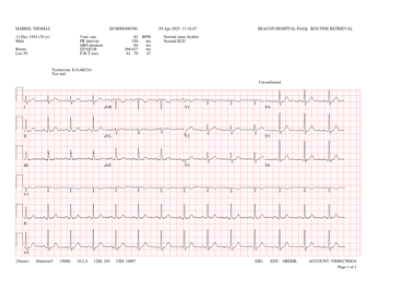

006.pdf: 2 page(s)
  ➜ Saved: 006_raw_pg2.png


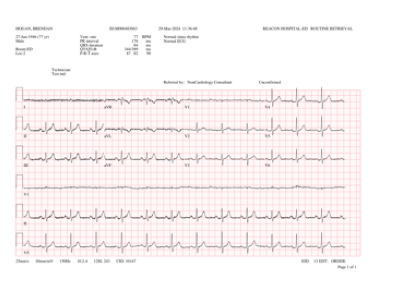

009.pdf: 4 page(s)
  ➜ Saved: 009_raw_pg2.png


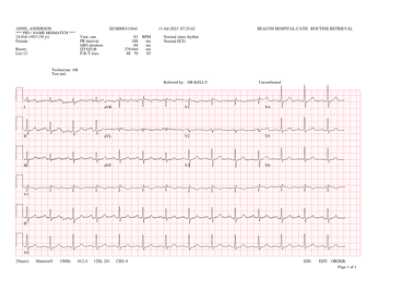

In [56]:
# ## 📄 Scan Input PDFs and Extract ECG Page

# Some ECG PDFs contain multiple pages:
# - Page 1 is usually a title or cover page
# - Page 2 often contains the most recent 12-lead ECG (most relevant for analysis)

# This block:
# - Converts each PDF into one or more images
# - If multi-page, saves page 2 as a PNG
# - If single-page, saves page 1 as a PNG
# - Outputs are saved to: input/processed_input/
# - Files for processing are named as: `pdf_name_raw_pg2.png` or `pdf_name_raw_pg1.png`

# Define the processed image output folder
PROCESSED_INPUT_FOLDER = INPUT_FOLDER / "processed_input"

# Find and process all PDFs
pdf_files = sorted(INPUT_FOLDER.glob("*.pdf"))
print(f"Found {len(pdf_files)} PDF file(s) in input/")
print("The variable 'pdf_files' holds the following file list:")
for file in pdf_files:
    print(f"  ➜ {file.name}")
print("-"*80)



for pdf_path in pdf_files:
    pages = convert_from_path(pdf_path, dpi=300)
    num_pages = len(pages)
    print(f"{pdf_path.name}: {num_pages} page(s)")

    if num_pages > 1:
        selected_page = pages[1]  # page 2
        suffix = "raw_pg2"
    else:
        selected_page = pages[0]  # page 1
        suffix = "raw_pg1"

    out_path = PROCESSED_INPUT_FOLDER / f"{pdf_path.stem}_{suffix}.png"
    selected_page.save(out_path)
    print(f"  ➜ Saved: {out_path.name}")

    # Show a 10% size preview of the extracted page
    preview = selected_page.resize(
        (int(selected_page.width * 0.1), int(selected_page.height * 0.1))
    )
    plt.figure(figsize=(6, 3))
    plt.imshow(preview)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

## 🟥 Detect and Crop Red ECG Grid Box

Each processed PNG image contains a full page ECG. We now extract the main red grid box where the waveform is plotted.

We define the `find_ecg_grid_box()` function which works as follows:

1. Converts the image to HSV color space
2. Filters out red-colored pixels using two hue ranges (0–10 and 160–180)
3. Uses morphological operations to clean the mask
4. Finds the largest red contour (assumed to be the ECG grid)
5. Crops and returns that bounding box

We'll apply this to each file in `input/processed_input/`, save the result to `output/`, and display a 10% preview.

### How `find_ecg_grid_box()` Works

This function isolates and crops the red ECG plotting area using:

### Libraries Used:
- `PIL.Image` + `numpy`: to convert and manipulate image pixel data
- `cv2` (OpenCV): for color-space conversion, masking, and contour detection

### Key Steps:
1. **Convert to HSV color space**  
   - HSV makes it easier to isolate color ranges (like "red") than RGB

2. **Define red hue ranges**  
   - ECG grids are often printed in red or pink
   - We use two hue bands in HSV:  
     - Hue 0–10 (pure red)  
     - Hue 160–180 (wraparound reds)

3. **Create a binary mask of red areas**

4. **Clean the mask using morphological closing**  
   - Removes small holes and merges nearby grid lines

5. **Find contours**  
   - We extract all red blobs and assume the largest one is the ECG grid

6. **Crop and return the bounding box around the largest red contour**

### What is HSV Color Space?

**HSV** stands for:
- **H**ue – the type of color (e.g., red, green, blue)
- **S**aturation – the intensity or purity of the color
- **V**alue (or brightness) – how light or dark the color is

While digital images are typically stored in **RGB** (Red, Green, Blue), HSV is often better for image analysis because it separates **color (hue)** from **brightness (value)**.

Saved ECG grid: 005_grid_pg2.png


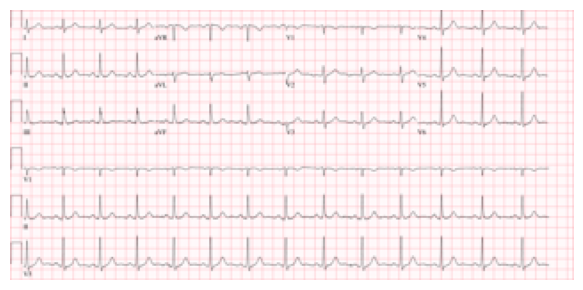

Saved ECG grid: 006_grid_pg2.png


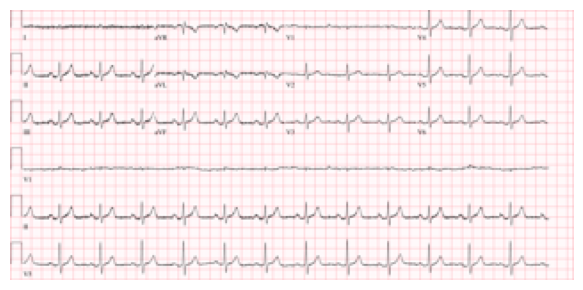

Saved ECG grid: 009_grid_pg2.png


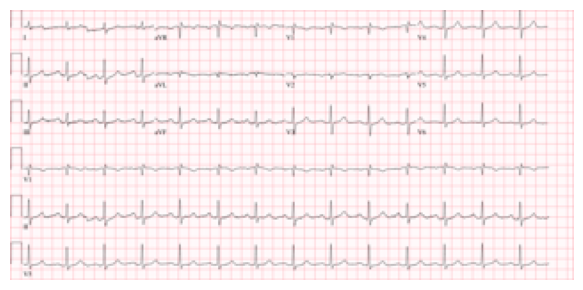

In [57]:
# List all PNGs in the processed input folder
processed_images = sorted((INPUT_FOLDER / "processed_input").glob("*.png"))


def find_ecg_grid_box(img):
    """Extracts the main red ECG box from the image using HSV filtering."""
    rgb = np.array(img)
    hsv = cv2.cvtColor(rgb, cv2.COLOR_RGB2HSV)

    # Define red hue range in HSV
    lower_red1 = np.array([0, 50, 100])
    upper_red1 = np.array([10, 255, 255])
    lower_red2 = np.array([160, 50, 100])
    upper_red2 = np.array([180, 255, 255])

    # Create red mask
    mask1 = cv2.inRange(hsv, lower_red1, upper_red1)
    mask2 = cv2.inRange(hsv, lower_red2, upper_red2)
    red_mask = cv2.bitwise_or(mask1, mask2)

    # Clean the mask using morphological closing
    kernel = np.ones((5, 5), np.uint8)
    cleaned = cv2.morphologyEx(red_mask, cv2.MORPH_CLOSE, kernel)

    # Find the largest red box
    contours, _ = cv2.findContours(cleaned, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        raise RuntimeError("No red ECG box found")

    largest = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(largest)

    return img.crop((x, y, x + w, y + h))

for img_path in processed_images:
    try:
        # Load image
        img = Image.open(img_path)
        
        # Extract red ECG grid box
        ecg_box = find_ecg_grid_box(img)

        # Save extracted box to output/ with _grid suffix
        out_path = OUTPUT_FOLDER / f"{img_path.stem.replace('_raw_', '_grid_')}.png"
        ecg_box.save(out_path)
        print(f"Saved ECG grid: {out_path.name}")

        # Show a preview (resized)
        preview = ecg_box.resize((int(ecg_box.width * 0.1), int(ecg_box.height * 0.1)))
        plt.figure(figsize=(6, 3))
        plt.imshow(preview)
        plt.axis('off')
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Could not process {img_path.name}: {e}")

## 📉 Extract Rhythm Strip from ECG Grid

In this step:
- We divide the ECG grid vertically into 6 equal-height segments
- We extract **only the 5th segment** (zero-indexed as row 4)

Our 12-lead ECG appear to be divided into **6 horizontal rows**:

| Row | Content                             |
|-----|-------------------------------------|
| 1   | Leads I, II, III                    |
| 2   | Leads aVR, aVL, aVF                 |
| 3   | Leads V1, V2, V3                    |
| 4   | Leads V4, V5, V6                    |
| 5   | **Lead II rhythm strip** (long)     |
| 6   | **V5 rhythm strip** (long, optional)|


You could extend the code later to also extract **row 6** (V5 rhythm) if needed.

Found 3 ECG grid image(s) to process for rhythm strip.
Saved rhythm strip to: output/005_strip_pg2.png


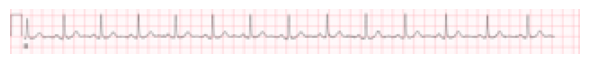

Saved rhythm strip to: output/006_strip_pg2.png


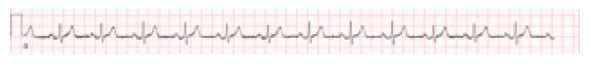

Saved rhythm strip to: output/009_strip_pg2.png


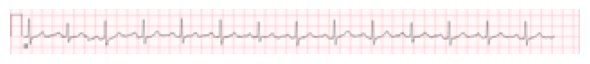

In [58]:

def extract_rhythm_strip_from_box(box_img, panel_index=4, total_panels=6):
    """
    Extract a specific horizontal panel from the ECG grid.
    Default is row 5 (panel_index=4) which contains the Lead II rhythm strip.
    """
    w, h = box_img.size
    panel_height = h // total_panels
    y0 = panel_index * panel_height
    y1 = (panel_index + 1) * panel_height
    return box_img.crop((0, y0, w, y1))

# Process all grid images saved earlier
grid_images = sorted(OUTPUT_FOLDER.glob("*_grid_*.png"))
print(f"Found {len(grid_images)} ECG grid image(s) to process for rhythm strip.")

for img_path in grid_images:
    try:
        grid_img = Image.open(img_path)
        rhythm_strip = extract_rhythm_strip_from_box(grid_img, panel_index=4)

        # Save with _strip_ in filename
        out_path = OUTPUT_FOLDER / f"{img_path.stem.replace('_grid_', '_strip_')}.png"
        rhythm_strip.save(out_path)

        print(f"Saved rhythm strip to: {out_path.relative_to(BASE_PATH)}")

        # 10% preview
        preview = rhythm_strip.resize((
            int(rhythm_strip.width * 0.1),
            int(rhythm_strip.height * 0.1)
        ))
        plt.figure(figsize=(6, 3))
        plt.imshow(preview)
        plt.axis('off')
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error extracting from {img_path.name}: {e}")

## 🧠 Digitize ECG Trace (Black on White + X:Y Coordinates)

This step:
- Removes the red grid and background from the extracted rhythm strip
- Inverts the image to get a **black trace on white background**
- Extracts the (x, y) coordinates of the darkest part of the signal at each column
- Saves:
  - The binarized image as `*_digitized.png`
  - The coordinates as `*_trace.csv`

🎯 Found 3 rhythm strip image(s) to digitize.
🖼️ Saved digitized trace image: output/005pg2_digitized.png
📈 Saved trace coordinates to: output/005pg2_trace.csv


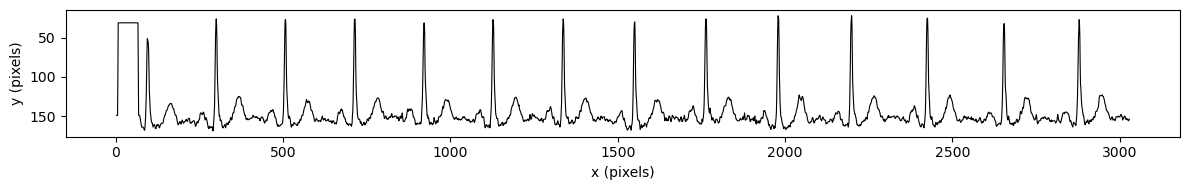

🖼️ Saved digitized trace image: output/006pg2_digitized.png
📈 Saved trace coordinates to: output/006pg2_trace.csv


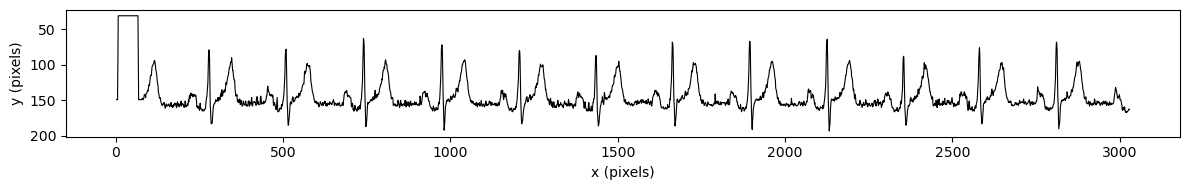

🖼️ Saved digitized trace image: output/009pg2_digitized.png
📈 Saved trace coordinates to: output/009pg2_trace.csv


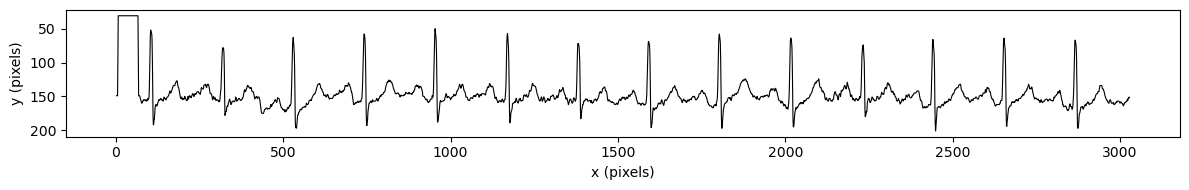

In [59]:


def digitize_ecg_trace(strip_img_path, output_folder):
    """
    Given a rhythm strip image path, this function:
    - Masks the red grid/background
    - Isolates the trace
    - Inverts for black-on-white
    - Extracts (x, y) coordinates
    - Saves both image and .csv trace
    """
    base = strip_img_path.stem.replace("_strip_", "")
    save_image_path = output_folder / f"{base}_digitized.png"
    save_csv_path = output_folder / f"{base}_trace.csv"

    # Step 1: Load and convert to HSV
    rgb = np.array(Image.open(strip_img_path))
    hsv = cv2.cvtColor(rgb, cv2.COLOR_RGB2HSV)

    # Define red regions
    lower_red1 = np.array([0, 50, 100])
    upper_red1 = np.array([10, 255, 255])
    lower_red2 = np.array([160, 50, 100])
    upper_red2 = np.array([180, 255, 255])
    red_mask1 = cv2.inRange(hsv, lower_red1, upper_red1)
    red_mask2 = cv2.inRange(hsv, lower_red2, upper_red2)
    full_red_mask = cv2.bitwise_or(red_mask1, red_mask2)

    # Invert red mask, keep dark non-red areas
    non_red = cv2.bitwise_not(full_red_mask)
    v = hsv[:, :, 2]
    dark = (v < 90).astype(np.uint8) * 255
    trace_mask = cv2.bitwise_and(non_red, dark)

    # Binarize and invert: black trace, white background
    trace_binary = (trace_mask > 0).astype(np.uint8) * 255
    trace_inverted = 255 - trace_binary

    # Save image
    Image.fromarray(trace_inverted).save(save_image_path)
    print(f"🖼️ Saved digitized trace image: {save_image_path.relative_to(BASE_PATH)}")

    # Step 2: Extract (x, y) coordinates
    ys, xs = np.where(trace_inverted < 128)
    df_trace = pd.DataFrame({'x_pixel': xs, 'y_pixel': ys})
    trace = df_trace.groupby('x_pixel')['y_pixel'].min()

    # Save coordinates
    trace_df = trace.reset_index()
    trace_df.columns = ['x_pixel', 'y_pixel']
    trace_df.to_csv(save_csv_path, index=False)
    print(f"📈 Saved trace coordinates to: {save_csv_path.relative_to(BASE_PATH)}")

    # Preview
    plt.figure(figsize=(12, 2))
    plt.plot(trace.index, trace.values, color='black', linewidth=0.8)
    plt.gca().invert_yaxis()
    plt.xlabel("x (pixels)")
    plt.ylabel("y (pixels)")
    plt.tight_layout()
    plt.show()

    return trace_df

# Apply to all _strip_ images
strip_imgs = sorted(OUTPUT_FOLDER.glob("*_strip_*.png"))
print(f"🎯 Found {len(strip_imgs)} rhythm strip image(s) to digitize.")

for strip_path in strip_imgs:
    try:
        digitize_ecg_trace(strip_path, OUTPUT_FOLDER)
    except Exception as e:
        print(f"⚠️ Failed to digitize {strip_path.name}: {e}")

## 🧠 Learning Panel: Understanding ECG Calibration

When ECGs are digitized from paper or scanned files, the pixel values represent the signal, but these pixels must be translated into real physiological units: **milliseconds (ms)** for time and **millivolts (mV)** for voltage.  
Every standard ECG begins with a **calibration pulse** – usually 1 mV in height and 250 ms in width – to serve as a reference for interpreting amplitudes and durations.  
The calibration is printed on the ECG and is usually as in this case but not always 25mm/s and 10mm/mV. The sampling frequency of the ECG machine is also provided ie 150Hz.   
In the grid one small box is 1mm square. One large box is 5mm x 5mm.  
This script walks through how we **automatically detect and interpret the calibration pulse** using only the digitized trace stored in a CSV file.  
We will then be able to calculate a pixel to mV and pixel to ms ratio and transform the trace to physiological units.  
In production we will save this new trace as new columns 'x_ms' and 'y_mv' in our csv file.  

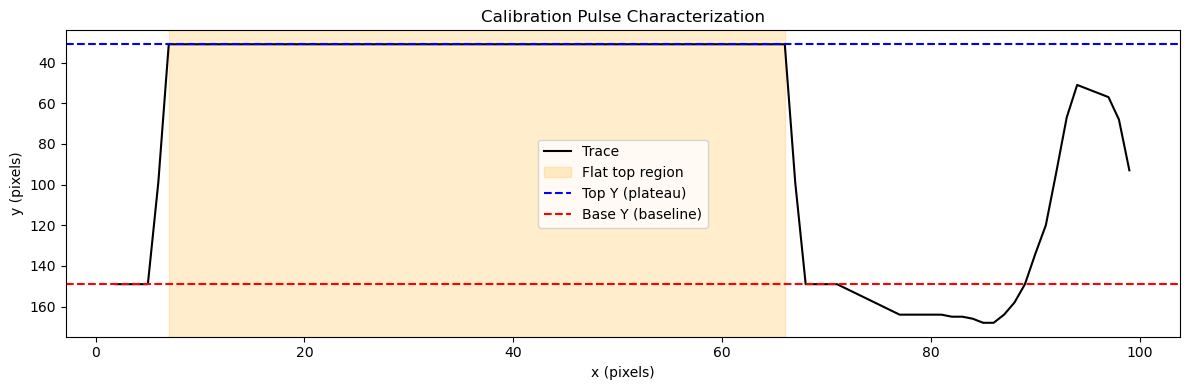

📏 Pulse width: 59 px (→ 250 ms)
📐 Pulse height: 118.0 px (→ 1 mV)


In [65]:
# 📂 Step 1: Select a sample digitized ECG trace from the output folder
# We pick the first _trace.csv file as an example
trace_files = sorted(OUTPUT_FOLDER.glob("*_trace.csv"))
csv_path = trace_files[0]  # Just for demo – we don't modify this file
df_trace = pd.read_csv(csv_path)

# 🛠️ Step 2: Clean and standardize the column names
df_trace.columns = df_trace.columns.str.strip().str.lower()

# 🔍 Step 3: Analyze the calibration pulse at the start of the trace
def analyze_calibration_pulse(df_trace, x_max=100, flat_tol=1):
    """
    Estimate calibration pulse height and width from digitized trace.

    Parameters:
        df_trace (pd.DataFrame): DataFrame with 'x_pixel' and 'y_pixel' columns
        x_max (int): Only consider first x_max horizontal pixels (where pulse appears)
        flat_tol (int): Acceptable variation in y-pixels for the flat top

    Returns:
        dict: Pixel measurements and pulse boundary positions
    """

    # 🪄 Logic: Look only at the leftmost part of the trace (the calibration pulse appears at the start)
    df = df_trace[df_trace['x_pixel'] < x_max].copy()

    # 🧱 Step 3a: The pulse has a flat "top" – we find its most common y-value
    top_y = df['y_pixel'].mode()[0]
    
    # 📏 Define the flat-top region of the pulse using a tolerance (e.g. ±1 pixel)
    flat_top = df[(df['y_pixel'] >= top_y - flat_tol) & (df['y_pixel'] <= top_y + flat_tol)]
    if flat_top.empty:
        raise ValueError("No flat region detected at pulse top")

    # ⏱️ Step 3b: Extract horizontal extent of the pulse (for duration)
    start_x = flat_top['x_pixel'].min()
    end_x = flat_top['x_pixel'].max()

    # 🔍 Step 3c: Estimate vertical baseline from flat region before the upstroke
    pre_pulse = df[df['x_pixel'] < start_x]
    window = pre_pulse[pre_pulse['x_pixel'] > start_x - 10]  # e.g. 10 pixels before

    if window.empty:
        raise ValueError("No data found before the pulse to estimate baseline.")

    # Optional: filter within tolerance of the mode to ensure stability
    baseline_mode = window['y_pixel'].mode()[0]
    stable_baseline = window[np.abs(window['y_pixel'] - baseline_mode) <= 1]

    # Final baseline value
    base_y = stable_baseline['y_pixel'].median() if not stable_baseline.empty else window['y_pixel'].median()

    # 🧮 Compute pulse height and width in pixels
    height = base_y - top_y
    width = end_x - start_x

    # 🖼️ Plot of the calibration pulse showing detection landmarks
    plt.figure(figsize=(12, 4))
    plt.plot(df['x_pixel'], df['y_pixel'], label="Trace", color='black')
    plt.axvspan(start_x, end_x, color='orange', alpha=0.2, label="Flat top region")
    plt.axhline(top_y, color='blue', linestyle='--', label="Top Y (plateau)")
    plt.axhline(base_y, color='red', linestyle='--', label="Base Y (baseline)")
    plt.gca().invert_yaxis()  # Flip y-axis to match ECG appearance
    plt.xlabel("x (pixels)")
    plt.ylabel("y (pixels)")
    plt.title("Calibration Pulse Characterization")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 📌 Note:
    # From the image, the upstroke of the calibration pulse is NEARLY vertical.
    # In our test file, it deviates by only ~1 pixel.
    # This is likely a digitization artifact from rasterization, binarization, or line thickness.
    # It's not clinically meaningful and does not affect the pulse calibration.

    print(f"📏 Pulse width: {width} px (→ 250 ms)")
    print(f"📐 Pulse height: {height} px (→ 1 mV)")

    return {
        'height_px': height,
        'width_px': width,
        'start_x': start_x,
        'end_x': end_x,
        'top_y': top_y,
        'base_y': base_y,
    }

# 📊 Step 4: Run the calibration analysis
# Print the digitised trace with physiological units
calibration_info = analyze_calibration_pulse(df_trace)

# ✅ Summary:
# - We have detected a calibration pulse in the first ~100 pixels of the trace
# - The vertical height corresponds to 1 mV
# - The horizontal width corresponds to 250 ms
# - This provides the scaling to convert pixel units into real ECG units (mV and ms)

## 🏁 Final Processing.  
### Print and save correctly Calibrated & Scaled Rhythm Strip

🚀 Found 3 file(s) to calibrate.

📄 Processing: 005pg2_trace.csv
📏 Pulse width: 59 px (→ 250 ms)
📐 Pulse height: 118.0 px (→ 1 mV)
✅ Calibrated CSV saved: 005pg2_trace_calibrated.csv
🖼️ Saved calibrated plot: 005pg2_trace_calibrated.png


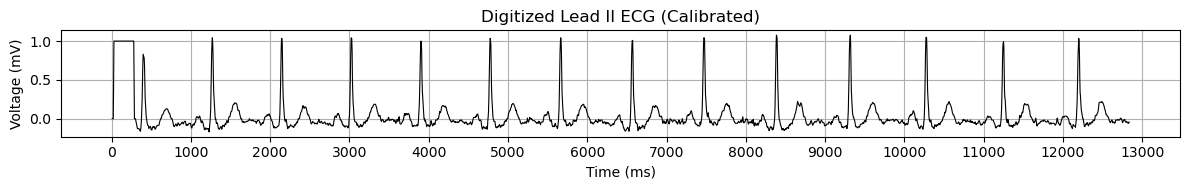


📄 Processing: 006pg2_trace.csv
📏 Pulse width: 59 px (→ 250 ms)
📐 Pulse height: 118.0 px (→ 1 mV)
✅ Calibrated CSV saved: 006pg2_trace_calibrated.csv
🖼️ Saved calibrated plot: 006pg2_trace_calibrated.png


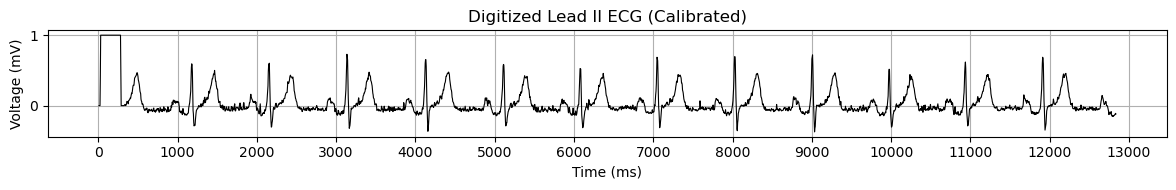


📄 Processing: 009pg2_trace.csv
📏 Pulse width: 59 px (→ 250 ms)
📐 Pulse height: 118.0 px (→ 1 mV)
✅ Calibrated CSV saved: 009pg2_trace_calibrated.csv
🖼️ Saved calibrated plot: 009pg2_trace_calibrated.png


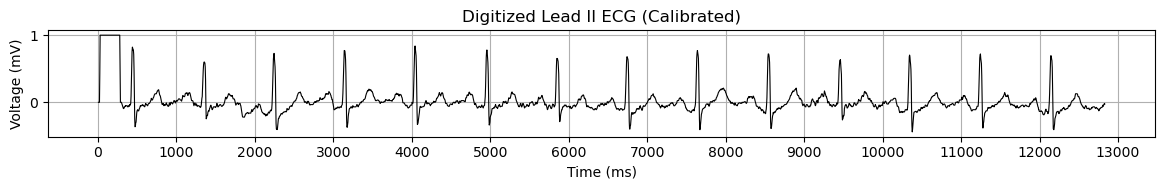

In [ ]:
# --- Analyze calibration pulse ---
def analyze_calibration_pulse(df_trace, x_max=100, flat_tol=1):
    """
    Analyze the calibration pulse at the start of a digitized ECG trace.

    Parameters:
        df_trace (pd.DataFrame): ECG trace with 'x_pixel' and 'y_pixel' columns
        x_max (int): Only analyze first x_max horizontal pixels
        flat_tol (int): Tolerance in y-pixels for identifying the flat-top

    Returns:
        dict: Pulse geometry and boundaries
    """
    df = df_trace[df_trace['x_pixel'] < x_max].copy()

    top_y = df['y_pixel'].mode()[0]
    flat_top = df[(df['y_pixel'] >= top_y - flat_tol) & (df['y_pixel'] <= top_y + flat_tol)]
    if flat_top.empty:
        raise ValueError("No flat region detected at pulse top")

    start_x = flat_top['x_pixel'].min()
    end_x = flat_top['x_pixel'].max()

    # Baseline from short stable segment before upstroke
    window = df[df['x_pixel'].between(start_x - 10, start_x - 1)]
    if window.empty:
        raise ValueError("No baseline segment found before calibration pulse")

    baseline_mode = window['y_pixel'].mode()[0]
    stable_baseline = window[abs(window['y_pixel'] - baseline_mode) <= 1]
    base_y = stable_baseline['y_pixel'].median() if not stable_baseline.empty else window['y_pixel'].median()

    height = base_y - top_y
    width = end_x - start_x

    print(f"📏 Pulse width: {width} px (→ 250 ms)")
    print(f"📐 Pulse height: {height} px (→ 1 mV)")

    return {
        'height_px': height,
        'width_px': width,
        'start_x': start_x,
        'end_x': end_x,
        'top_y': top_y,
        'base_y': base_y,
    }

# --- Plot calibrated ECG ---
def plot_calibrated_trace(df, save_path=None):
    """
    Plot calibrated ECG trace using time (ms) and voltage (mV).

    Parameters:
        df (pd.DataFrame): Must contain 'x_ms' and 'y_mv'
        save_path (Path): Optional PNG path to save the plot
    """
    plt.figure(figsize=(12, 2))
    plt.plot(df['x_ms'], df['y_mv'], color='black', linewidth=0.8)
    plt.xlabel("Time (ms)")
    plt.ylabel("Voltage (mV)")
    plt.title("Digitized Lead II ECG (Calibrated)")
    plt.xticks(ticks=range(0, int(df['x_ms'].max()) + 1000, 1000))
    plt.grid(True)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300)
        print(f"🖼️ Saved calibrated plot: {save_path.name}")
    plt.show()

# --- Process all trace files ---
trace_files = sorted(OUTPUT_FOLDER.glob("*_trace.csv"))
print(f"🚀 Found {len(trace_files)} file(s) to calibrate.")

for csv_path in trace_files:
    try:
        print(f"\n📄 Processing: {csv_path.name}")
        df = pd.read_csv(csv_path)

        # Expecting x_pixel, y_pixel from digitizer
        cal = analyze_calibration_pulse(df)

        px_per_mv = cal['height_px']
        px_per_ms = cal['width_px'] / 250  # 250 ms standard

        df['x_ms'] = df['x_pixel'] / px_per_ms
        df['y_mv'] = -(df['y_pixel'] - cal['base_y']) / px_per_mv

        # Save calibrated CSV
        calibrated_csv = csv_path.with_name(csv_path.stem + "_calibrated.csv")
        df[['x_pixel', 'y_pixel', 'x_ms', 'y_mv']].to_csv(calibrated_csv, index=False)
        print(f"✅ Calibrated CSV saved: {calibrated_csv.name}")

        # Save plot
        plot_path = csv_path.with_name(csv_path.stem + "_calibrated.png")
        plot_calibrated_trace(df, save_path=plot_path)

    except Exception as e:
        print(f"❌ Failed to process {csv_path.name}: {e}")